In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Python Pckages
import random
import string
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt

# ML Packages
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# ML Classifiers
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Deep ML Packages
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dense, Activation, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow import keras

# ML Metrics
from sklearn.metrics import accuracy_score

In [ ]:
gpu = tf.test.gpu_device_name()
gpu

'/device:GPU:0'

In [ ]:
removing_characters = list(string.punctuation+'0123456789'+'\t'+'\n')
def data_preprocessing(df):
  # Removing NaN Data
  df = df.dropna()

  # Seperating Male Indices and Female Indices
  male_df = []
  female_df = []
  for i in range(df.shape[0]):
    if df.iloc[i, 1] == 'male':
      male_df.append(i)
    elif df.iloc[i, 1] == 'female':
      female_df.append(i)
    df.iloc[i, 0] = str(df.iloc[i, 0]).lower()
    # Removing Special Characters and Digits
    temp = ''
    for char in df.iloc[i, 0]:
      if char not in removing_characters:
        temp += char
    df.iloc[i, 0] = temp
    
  # Creating New Dataset where Number of Male == Number of Female
  sampled_indices = list(random.sample(male_df, len(female_df))) + female_df
  sampled_df = df.iloc[sampled_indices, :]

  for i in range(sampled_df.shape[0]):
    if sampled_df.iloc[i, 1] == "male":
      sampled_df.iloc[i, 1] = "M"
    else:
      sampled_df.iloc[i, 1] = "F"
  
  sampled_df = sampled_df.sample(frac=1)

  return sampled_df

# Extracting Maximum Length of All The Names
def max_length_extractor_names(names):
  max_length = 0
  for name in names:
    if max_length < len(name):
      max_length = len(name)
  return max_length

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    temp = np.zeros(len_vocabulary);
    temp[i] = 1
    return list(temp)

# Truncate names and create the matrix
def prepare_X(X):
    new_list = []
    trunc_train_name = [str(i)[0:maxlen] for i in X]

    for i in trunc_train_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        new_list.append(tmp)

    return new_list

# Label Encoding of y
def prepare_y(y):
    new_list = []
    for i in y:
        if i == 'M':
            new_list.append([1,0])
        else:
            new_list.append([0,1])
    return new_list

In [ ]:
# Load our data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/Filtered_Dataset.csv")
df.head()

,CUSTOMER_NAME,GENDER
0,Md. Jamal,male
1,Beplob Chakrabarti,male
2,Mohammed Amran,male
3,Samim Ahmed,male
4,Md. Mamunor Rashid,male


In [ ]:
df = data_preprocessing(df)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:

,CUSTOMER_NAME,GENDER
2603,delayer hossen,M
5196,khaled hussain,M
14852,md osman gani bhuiyan,M
11511,most jesmin sultana,F
7700,md yasin arafat emon,M


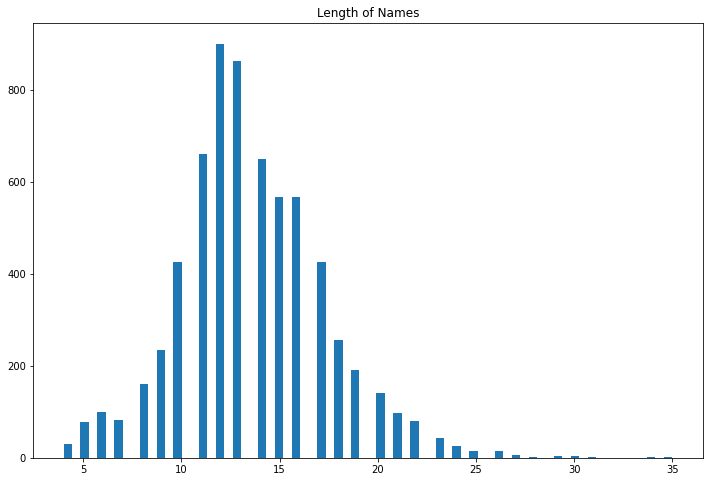

In [ ]:
customer_names = df['CUSTOMER_NAME'].apply(lambda x: x.lower())
gender = df['GENDER']
plt.figure(figsize=(12,8))
plt.hist([len(name) for name in customer_names], bins=72)
plt.title("Length of Names")
plt.show()

In [ ]:
print("Male : " + str(sum(gender=='M')))
print("Female : " + str(sum(gender=='F')))

Male : 3316
Female : 3316


In [ ]:
vocabulary = list(set(' '.join([str(i) for i in customer_names])))
vocabulary.append('END')
len_vocabulary = len(vocabulary)
print(len_vocabulary)
vocabulary.sort()
print(vocabulary)

28
[' ', 'END', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
char_index = dict((c, i) for i, c in enumerate(vocabulary))
char_index

{' ': 0,
 'END': 1,
 'a': 2,
 'b': 3,
 'c': 4,
 'd': 5,
 'e': 6,
 'f': 7,
 'g': 8,
 'h': 9,
 'i': 10,
 'j': 11,
 'k': 12,
 'l': 13,
 'm': 14,
 'n': 15,
 'o': 16,
 'p': 17,
 'q': 18,
 'r': 19,
 's': 20,
 't': 21,
 'u': 22,
 'v': 23,
 'w': 24,
 'x': 25,
 'y': 26,
 'z': 27}

In [ ]:
maxlen = max_length_extractor_names(customer_names)
labels = len(list(set(gender)))
print(f"Maximum Name Length: {maxlen} \t Labels: {labels}")

Maximum Name Length: 35 	 Labels: 2


In [ ]:
X = []
y = []
X = prepare_X(customer_names.values)
y = prepare_y(gender)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(512, return_sequences=True), 
                        backward_layer=LSTM(512, return_sequences=True, go_backwards=True), 
                        input_shape=(maxlen,len_vocabulary)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(512)))
model.add(Dropout(0.2))
model.add(Dense(2, activity_regularizer=l2(0.002)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

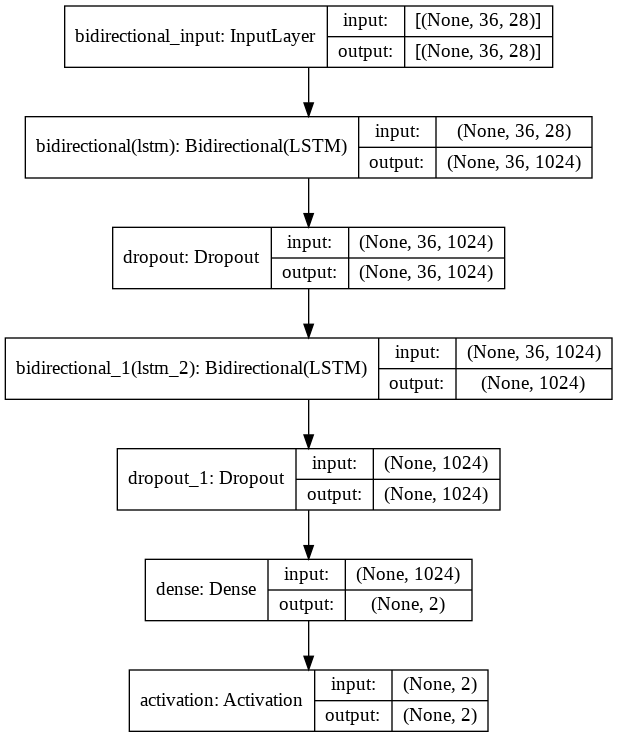

In [ ]:
plot_model(model, to_file='/content/drive/MyDrive/Colab Notebooks/Models/Model.png', show_shapes=True, expand_nested=True)

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/Models/Model.h5', monitor='val_loss', mode='min', verbose=1)
reduce_lr_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='max')

In [ ]:
batch_size = 256
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=35, 
                    verbose=1, validation_data =(X_test, y_test), 
                    callbacks=[callback, mc, reduce_lr_acc])

Epoch 1/35
19/19 [==============================] - 23s 816ms/step - loss: 0.6195 - accuracy: 0.6147 - val_loss: 0.3427 - val_accuracy: 0.8583

Epoch 00001: saving model to /content/drive/MyDrive/Colab Notebooks/Models/Model.h5
Epoch 2/35
19/19 [==============================] - 6s 339ms/step - loss: 0.3389 - accuracy: 0.8574 - val_loss: 0.2806 - val_accuracy: 0.8879

Epoch 00002: saving model to /content/drive/MyDrive/Colab Notebooks/Models/Model.h5
Epoch 3/35
19/19 [==============================] - 6s 338ms/step - loss: 0.2786 - accuracy: 0.8849 - val_loss: 0.2701 - val_accuracy: 0.8854

Epoch 00003: saving model to /content/drive/MyDrive/Colab Notebooks/Models/Model.h5
Epoch 4/35
19/19 [==============================] - 6s 343ms/step - loss: 0.2589 - accuracy: 0.8990 - val_loss: 0.2564 - val_accuracy: 0.8910

Epoch 00004: saving model to /content/drive/MyDrive/Colab Notebooks/Models/Model.h5
Epoch 5/35
19/19 [==============================] - 6s 342ms/step - loss: 0.2477 - accuracy

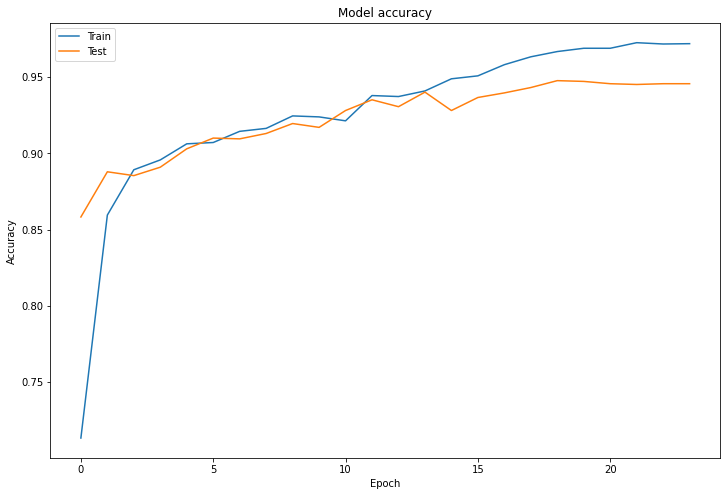

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

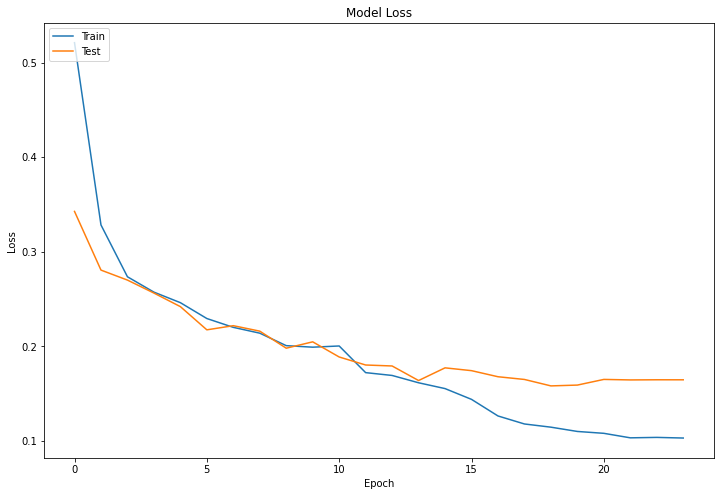

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
test_names = ["Rayhan Rashid",
              "Rani",
              "Afsana Yeasmin Mili",
              "Rayhana",
              "Md. Zahid Hossain Khan", 
              "Shahriar Haque", 
              "Ashique Jubayer",
              "Nowsin", 
              "Shajedul Islam",
              "Saif Ahmed Anik", 
              "Toriqul Islam",
              "Afrina Yeasmin Mithila",
              "MD. Khalid Hossain Khan",
              "Md. Faruque Hossain Khan",
              "Md. Abdul Aziz Khan",
              "Samsun Nahar",
              "Farhana Sharmin",
              "Mahbub Azam",
              "Roni Hauladar", 
              "Chowdhuri Mofizur Rahman",
              "Sajid Ahmed",
              "Swakkhar Swatabda",
              "Sabila Nowshin",
              "Rifat Jabin",
              "Tithi",
              "Tanvir Rashid",
              "Kamrul Islam Tushar",
              "Sahanaj",
              "Suma Akhter",
              "Nishat Fariha",
              "Faiza Alam",
              "Ripon Khan",
              "Ridita Afrin"]

In [ ]:
for i in range(len(test_names)):
  temp = ''
  for char in test_names[i]:
    if char not in removing_characters:
      temp += char
  test_names[i] = temp
test_names

['Rayhan Rashid',
 'Rani',
 'Afsana Yeasmin Mili',
 'Rayhana',
 'Md Zahid Hossain Khan',
 'Shahriar Haque',
 'Ashique Jubayer',
 'Nowsin',
 'Shajedul Islam',
 'Saif Ahmed Anik',
 'Toriqul Islam',
 'Afrina Yeasmin Mithila',
 'MD Khalid Hossain Khan',
 'Md Faruque Hossain Khan',
 'Md Abdul Aziz Khan',
 'Samsun Nahar',
 'Farhana Sharmin',
 'Mahbub Azam',
 'Roni Hauladar',
 'Chowdhuri Mofizur Rahman',
 'Sajid Ahmed',
 'Swakkhar Swatabda',
 'Sabila Nowshin',
 'Rifat Jabin',
 'Tithi',
 'Tanvir Rashid',
 'Kamrul Islam Tushar',
 'Sahanaj',
 'Suma Akhter',
 'Nishat Fariha',
 'Faiza Alam',
 'Ripon Khan',
 'Ridita Afrin']

In [ ]:
X_pred = prepare_X([name.lower() for name in test_names])
predictions = model.predict(X_pred)
predictions

array([[0.7765872 , 0.22341277],
       [0.07147799, 0.92852205],
       [0.00732494, 0.9926751 ],
       [0.02179801, 0.9782019 ],
       [0.99214786, 0.00785218],
       [0.33386004, 0.66613996],
       [0.7907846 , 0.20921548],
       [0.42011344, 0.57988656],
       [0.984501  , 0.01549897],
       [0.9803125 , 0.01968749],
       [0.9919635 , 0.00803651],
       [0.00427662, 0.99572337],
       [0.9902621 , 0.00973791],
       [0.9930409 , 0.00695902],
       [0.98949754, 0.01050245],
       [0.00369116, 0.99630886],
       [0.5371526 , 0.46284738],
       [0.96279967, 0.0372003 ],
       [0.7312449 , 0.2687551 ],
       [0.97567356, 0.02432644],
       [0.9839295 , 0.01607047],
       [0.9426996 , 0.05730041],
       [0.14449959, 0.85550046],
       [0.44872123, 0.5512788 ],
       [0.01002685, 0.9899732 ],
       [0.8470056 , 0.15299444],
       [0.98313785, 0.01686215],
       [0.4174227 , 0.5825773 ],
       [0.01473526, 0.9852647 ],
       [0.15183882, 0.84816116],
       [0.

In [ ]:
test_prediction = ['M' if np.argmax(prediction) == 0 else 'F' for prediction in predictions]

In [ ]:
test_table = []
for i in range(len(test_names)):
  test_table.append([test_names[i], test_prediction[i]])
print("\n\n## Test Names Result ##\n")
print(tabulate(test_table, headers= ['Name', 'Gender']))



## Test Names Result ##

Name                      Gender
------------------------  --------
Rayhan Rashid             M
Rani                      F
Afsana Yeasmin Mili       F
Rayhana                   F
Md Zahid Hossain Khan     M
Shahriar Haque            F
Ashique Jubayer           M
Nowsin                    F
Shajedul Islam            M
Saif Ahmed Anik           M
Toriqul Islam             M
Afrina Yeasmin Mithila    F
MD Khalid Hossain Khan    M
Md Faruque Hossain Khan   M
Md Abdul Aziz Khan        M
Samsun Nahar              F
Farhana Sharmin           M
Mahbub Azam               M
Roni Hauladar             M
Chowdhuri Mofizur Rahman  M
Sajid Ahmed               M
Swakkhar Swatabda         M
Sabila Nowshin            F
Rifat Jabin               F
Tithi                     F
Tanvir Rashid             M
Kamrul Islam Tushar       M
Sahanaj                   F
Suma Akhter               F
Nishat Fariha             F
Faiza Alam                F
Ripon Khan                M
Ridita Af

In [ ]:
##### 50K Test Data #####

In [ ]:
# Loading Saved Model
model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Models/Model - Run 3.h5")

In [3]:
# Load test data
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/Dataset_0.6_Million.csv")
test_df.head()

,CUSTOMER_NAME,GENDER
0,Md Melon Mondol,male
1,Md Alauddin Khalifa,male
2,Dipok Das,male
3,Md. Faruq Hossen,male
4,Mst Saida Begum,female


In [4]:
print(test_df.shape)
test_df = test_df.dropna()
print(test_df.shape)

(620802, 2)
(620802, 2)


In [ ]:
with tf.device("/gpu:0"):
  for i in range(test_df.shape[0]):
    temp = ''
    for char in test_df.iloc[i, 0]:
      if char not in removing_characters:
        temp += char
    test_df.iloc[i, 0] = temp
    test_df.iloc[i, 0], test_df.iloc[i, 1] = str(test_df.iloc[i, 0]).lower(), str(test_df.iloc[i, 1]).lower()
    if test_df.iloc[i, 1] == 'male':
      test_df.iloc[i, 1] = 'M'
    else:
      test_df.iloc[i, 1] = 'F'
  test_df.head()

In [ ]:
with tf.device("/gpu:0"):
  final_accuracy = []
  final_predictions = []
  final_test_y = []
  final_test_X = []
  hop = 69905
  start = 0
  end = hop
  while end <= test_df.shape[0]:
    test_X, test_y = list(test_df.iloc[start:end, 0]), list(test_df.iloc[start:end, 1])
    test_X_pred = prepare_X(test_X)
    test_predictions = model.predict(test_X_pred)
    final_test_predictions = ['M' if np.argmax(prediction) == 0 else 'F' for prediction in test_predictions]
    final_test_X.append(test_X)
    final_test_y.append(test_y)
    final_predictions.append(final_test_predictions)
    accuracy = accuracy_score(test_y, final_test_predictions)
    final_accuracy.append(accuracy)
    start += hop
    end += hop
    print(f"Accuracy : {round(accuracy * 100, 2)}%")

Accuracy : 92.18%
Accuracy : 91.27%
Accuracy : 89.82%
Accuracy : 92.13%
Accuracy : 91.13%
Accuracy : 89.87%
Accuracy : 92.08%
Accuracy : 91.08%
Accuracy : 89.61%
Accuracy : 92.19%
Accuracy : 90.75%
Accuracy : 89.99%
Accuracy : 92.06%
Accuracy : 90.97%
Accuracy : 89.83%


In [ ]:
rX = []
rY = []
rP = []
for i in range(len(final_test_X)):
  for j in range(len(final_test_X[i])):
    rX.append(final_test_X[i][j])
    rY.append(final_test_y[i][j])
    rP.append(final_predictions[i][j])

In [ ]:
print(final_accuracy)

[0.9217795579715328, 0.912695801444818, 0.8981904012588513, 0.9212788784779343, 0.9112509834775767, 0.8987483012660039, 0.9207925041127244, 0.9108361347543095, 0.8960875473857378, 0.921922609255418, 0.907488734711394, 0.8998784064086975, 0.9206208425720621, 0.9096917244832272, 0.898290537157571]


In [ ]:
print(f"Accuracy : {round(np.mean(final_accuracy) * 100, 2)}%")

Accuracy : 91.0%


In [ ]:
result = pd.DataFrame(list(zip(rX, rY, rP)), columns=['Name', 'Original Gender', 'Predicted Gender'])
result.to_csv('/content/drive/MyDrive/Colab Notebooks/Results/Result(LSTM) - 1 Million.csv', index=False) 

In [5]:
result_06 = [0.9241142908689083, 0.9131542746318472, 0.9089822519901676, 0.8998263536522112, 0.9096362447285931, 0.920009922648445, 0.9127257966308098, 0.908463568094175, 0.8945493087973299, 0.9176420179058702, 0.9184989739079449, 0.9113727082064813, 0.9025099790271294, 0.8948650294296733]
result_10 = [0.9217795579715328, 0.912695801444818, 0.8981904012588513, 0.9212788784779343, 0.9112509834775767, 0.8987483012660039, 0.9207925041127244, 0.9108361347543095, 0.8960875473857378, 0.921922609255418, 0.907488734711394, 0.8998784064086975, 0.9206208425720621, 0.9096917244832272, 0.898290537157571]

In [6]:
result_16 = result_06 + result_10
result_16

[0.9241142908689083,
 0.9131542746318472,
 0.9089822519901676,
 0.8998263536522112,
 0.9096362447285931,
 0.920009922648445,
 0.9127257966308098,
 0.908463568094175,
 0.8945493087973299,
 0.9176420179058702,
 0.9184989739079449,
 0.9113727082064813,
 0.9025099790271294,
 0.8948650294296733,
 0.9217795579715328,
 0.912695801444818,
 0.8981904012588513,
 0.9212788784779343,
 0.9112509834775767,
 0.8987483012660039,
 0.9207925041127244,
 0.9108361347543095,
 0.8960875473857378,
 0.921922609255418,
 0.907488734711394,
 0.8998784064086975,
 0.9206208425720621,
 0.9096917244832272,
 0.898290537157571]

In [13]:
print("==> 1 Million Test Data\n")
for i in range(len(result_10)):
  print(f"Batch \t{i+1}: {round(result_10[i] * 100, 2)} %")
print(f"Average\t  : {round(np.mean(result_10) * 100, 2)} %")

print("\n\n==> 0.6 Million Test Data\n")
for i in range(len(result_06)):
  print(f"Batch \t{i+1}: {round(result_06[i] * 100, 2)} %")
print(f"Average\t  : {round(np.mean(result_06) * 100, 2)} %")

==> 1 Million Test Data

Batch 	1: 92.18 %
Batch 	2: 91.27 %
Batch 	3: 89.82 %
Batch 	4: 92.13 %
Batch 	5: 91.13 %
Batch 	6: 89.87 %
Batch 	7: 92.08 %
Batch 	8: 91.08 %
Batch 	9: 89.61 %
Batch 	10: 92.19 %
Batch 	11: 90.75 %
Batch 	12: 89.99 %
Batch 	13: 92.06 %
Batch 	14: 90.97 %
Batch 	15: 89.83 %
Average	  : 91.0 %


==> 0.6 Million Test Data

Batch 	1: 92.41 %
Batch 	2: 91.32 %
Batch 	3: 90.9 %
Batch 	4: 89.98 %
Batch 	5: 90.96 %
Batch 	6: 92.0 %
Batch 	7: 91.27 %
Batch 	8: 90.85 %
Batch 	9: 89.45 %
Batch 	10: 91.76 %
Batch 	11: 91.85 %
Batch 	12: 91.14 %
Batch 	13: 90.25 %
Batch 	14: 89.49 %
Average	  : 90.97 %


In [ ]:
print(f"Average Accuracy of 1.6 Million Data: {round(np.mean(result_16) * 100, 2)}%")

Average Accuracy of 1.6 Million Data: 90.99%


In [ ]:
# test_X_pred = prepare_X(test_X)
# test_predictions = model.predict(test_X_pred)
# test_predictions

In [ ]:
# final_test_predictions = ['M' if np.argmax(prediction) == 0 else 'F' for prediction in test_predictions]

In [ ]:
# accuracy = accuracy_score(test_y, final_test_predictions)
# print(f"Accuracy : {round(accuracy * 100, 2)}%")

In [ ]:
# result = pd.DataFrame(list(zip(test_X, test_y, final_test_predictions)), columns=['Name', 'Original Gender', 'Predicted Gender'])
# result.to_csv('/content/drive/MyDrive/Colab Notebooks/Results/Result(LSTM) - 0.6 Million.csv', index=False) 

In [ ]:
# Average Accuracy of 0.6 Million Data: 90.97%
# Average Accuracy of 1.0 Million Data: 91.00%
# Average Accuracy of 1.6 Million Data: 90.99%